# GPR
 * Implement log marginal likelihood optimization
 * Implement multiple kernels
     * linear
     * periodic
     * rational quadratic
 * Use HXDY to do log marginal likelihood optimization
#### Imports and Function Defs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import scipy.sparse.linalg

### Kernel Defs

In [2]:
#@nb.njit(cache=True)
def rbf(xp, xq, l, sf):
    return sf*sf*np.exp(-.5 * np.sum(np.power((xp-xq)/l, 2)))

### Kernel Derivative Defs

In [18]:
#@nb.njit(cache=True)
def rbf_prime(xp, xq, l, sf):
    x_diff = xp-xq
    result = np.empty(len(l)+1)
    
    l_power = 2.*sf*sf*np.exp(-.5 * np.sum(np.power(x_diff/l, 2)))*np.sum(x_diff/l)
    for i in range(len(l)): result[i] =  l_power/l[i]
        
    sf_prime = 2.*sf*np.exp(-.5 * np.sum(np.power(x_diff/l, 2)))
    result[-1] = sf_prime
    
    return result

### Covariance Matrix Calculations

In [19]:
#@nb.njit(parallel=True)
def K_XX(X, l, sf):
    cov = np.empty((len(X),len(X)))
    for i in range(len(X)):
        for j in range(i+1):
            cov[i,j] = cov[j,i] = rbf(X[i], X[j], l, sf)
    return cov

In [20]:
#@nb.njit(parallel=True)
def K_XY(X, Y, l, sf):
    cov = np.empty((len(Y),len(X)))
    for i in range(len(Y)):
        for j in range(len(X)):
            cov[i,j] = rbf(Y[i], X[j], l, sf)
    return cov

### Prediction Tools

In [21]:
#@nb.njit(parallel=True)
def predict(X, X_s, l, sf, k_xx_i_y, y_mean):
    return np.dot(K_XY(X, X_s, l, sf), k_xx_i_y) + y_mean

In [22]:
def fitPredict(X_train, y_train, X_test, l, sf):

    k_xx = K_XX(X_train, l, sf)
    y_mean = np.mean(y_train)
    k_xx_i_y = scipy.sparse.linalg.minres(k_xx, y_train-y_mean)[0] 
    pred = predict(X_train, X_test, l, sf, k_xx_i_y, y_mean)
    
    return pred

### $\theta$ Optimization Tools

In [23]:
def log_marginal_likelihood(x, y, l, sf):
    K = K_XX(x, l, sf)
    K_inv = np.linalg.pinv(K)
    
    term1 = -.5*np.log(np.linalg.det(K))
    term2 = -.5*((y.T @ K_inv @ y)[0,0])
    term3 = -(len(x)/2)*np.log(2.*np.pi)
    return term1 + term2 + term3

### Testing

In [24]:
x = np.arange(-np.pi, np.pi, 1e-2).reshape(-1,1)
y = (np.sin(x)**2).reshape(-1,1)

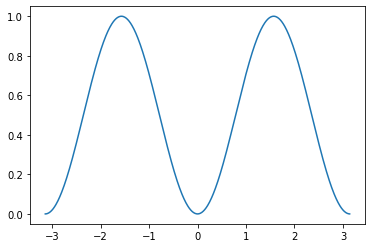

In [25]:
plt.plot(x, y);

In [26]:
def log_marginal_likelihood_prime(x, y, l, sf):
    
    K = K_XX(x, l, sf)
    K_inv = np.linalg.pinv(K)

    alpha = y.T @ K_inv

    kernel_der = np.empty((len(x), len(x), len(np.append(l, sf))))

    # idx = [slice(None)] * (myarray.ndim - 1) + [i] 
    # my_slice = myarray[idx]
    # The slice(None) is equivalent to choosing all elements in that index, and the last [i] selects a specific index for the last dimension.

    for i in range(len(x)):
        for j in range(len(x)):
            kernel_der[i,j] = rbf_prime(x[i], x[j], l, sf)

    der = np.zeros(len(np.append(l, sf)))
    for i in range(len(der)):
        idx = tuple([slice(None)]*(kernel_der.ndim-1) + [i])
        der[i] = (.5 * alpha @ kernel_der[idx] @ alpha.T)[0,0] 
        der[i] -= .5*np.trace(K_inv @ kernel_der[idx])
    return der

In [27]:
l_range = np.arange(.1, 2, 1e-3)

In [28]:
sf_range = np.arange(.1, 3, 1e-2)

In [29]:
z = np.empty((len(l_range), len(sf_range), 2))

In [ ]:
for i in range(len(l_range)):
    for j in range(len(sf_range)):
        z[i,j] = log_marginal_likelihood_prime(x[::100], y[::100], l_range[i]*np.ones(1), sf_range[j])

In [ ]:
l_range[100]

In [ ]:
sf_range[100]

In [ ]:
plt.plot(sf_range, z[100, :])

In [ ]:
plt.plot(l_range, z[:, 100])

In [68]:
p = fitPredict(x[::100], y[::100], x, 1.26*np.ones(1), 1.)

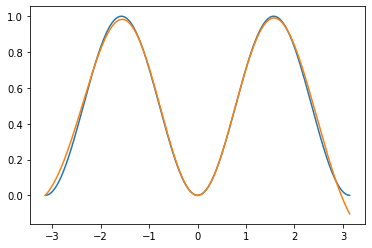

In [69]:
plt.plot(x, y, label='truth')
plt.plot(x, p, label='prediction');